In [1]:
import numpy as np
import os
import pickle

In [2]:
# IMPORTO I DATI PER VOTTIGNASCO

# Ottieni il percorso effettivo da una variabile d'ambiente
work_path = os.environ['WORK']  # Ottieni il valore della variabile d'ambiente WORK
v_test_OHE_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_month_OHE.npy")
v_test_image_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_normalized_image_sequences.npy")
v_test_target_dates_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_target_dates.npy")
v_test_images_dates = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_image_sequences_dates.npy"
v_test_normalization_factors_std_path  = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_std.npy")
v_test_normalization_factors_mean_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_mean.npy")

# Carica l'array numpy dai file
vottignasco_test_OHE         = np.load(v_test_OHE_path)
vottignasco_test_image       = np.load(v_test_image_path)
vottignasco_test_dates       = np.load(v_test_target_dates_path)
vottignasco_test_image_dates = np.load(v_test_images_dates)
vott_target_test_std         = np.load(v_test_normalization_factors_std_path) 
vott_target_test_mean        = np.load(v_test_normalization_factors_mean_path)


print(len(vottignasco_test_dates))
print(len(vottignasco_test_image))
print(len(vottignasco_test_OHE))

105
105
105


In [3]:
import matplotlib.pyplot as plt

def calculate_auc(x, y):
    """
    Calcola l'area sotto la curva (AUC) utilizzando il metodo del trapezio.

    :param x: Valori dell'asse x (frazione dei pixel/frame inseriti).
    :param y: Valori dell'asse y (errori calcolati).
    :return: Area sotto la curva.
    """
    return np.trapz(y, x)

def plot_combined_curves(all_errors_insertion, all_errors_deletion, title="", save_path=""):
    # Creazione della figura e dei due subplot (1 riga, 2 colonne)
    fig, axs = plt.subplots(1, 2, figsize=(11, 5))

    # Plot per la curva di inserimento
    max_len_insertion = max(map(len, all_errors_insertion))
    padded_array_insertion = np.full((len(all_errors_insertion), max_len_insertion), np.nan)
    for i, row in enumerate(all_errors_insertion):
        padded_array_insertion[i, :len(row)] = row  # Riempie solo le parti esistenti
    #mean_errors_for_insertion_vott = np.nanmean(all_errors_insertion, axis=0)
    mean_errors_for_insertion_vott = np.nanmean(padded_array_insertion, axis=0)

    #x_insertion = np.arange(0, mean_errors_for_insertion_vott.shape[0])
    x_insertion = np.linspace(0, 1, mean_errors_for_insertion_vott.shape[0])
    auc_insertion = calculate_auc(x_insertion, mean_errors_for_insertion_vott)
    auc_text_insertion = f'AUC = {auc_insertion:.2f}'
    axs[0].plot(x_insertion, mean_errors_for_insertion_vott, label=f'Error Curve, {auc_text_insertion}')
    #axs[0].scatter(x_insertion, mean_errors_for_insertion_vott, color='blue', zorder=3)


    axs[0].fill_between(x_insertion, mean_errors_for_insertion_vott, color='skyblue', alpha=0.4)
    axs[0].set_xlabel('Fraction of pixels inserted')
    axs[0].set_ylabel('Mean Squared Error')
    axs[0].grid(True, linestyle='--', alpha=0.6)
    axs[0].set_title('Mean Insertion Metric Curve')
    axs[0].legend()

    # Plot per la curva di cancellazione
    max_len_deletion = max(map(len, all_errors_deletion))
    padded_array_deletion = np.full((len(all_errors_deletion), max_len_deletion), np.nan)
    for i, row in enumerate(all_errors_deletion):
        padded_array_deletion[i, :len(row)] = row  # Riempie solo le parti esistenti
    mean_errors_for_deletion_vott = np.nanmean(padded_array_deletion, axis=0)
    #mean_errors_for_deletion_vott = np.nanmean(all_errors_deletion, axis=0)

    #x_deletion = np.arange(0, mean_errors_for_deletion_vott.shape[0])
    x_deletion = np.linspace(0, 1, mean_errors_for_deletion_vott.shape[0])
    auc_deletion = calculate_auc(x_deletion, mean_errors_for_deletion_vott)
    auc_text_deletion = f'AUC = {auc_deletion:.2f}'

    axs[1].plot(x_deletion, mean_errors_for_deletion_vott, label=f'Error Curve, {auc_text_deletion}')
    #axs[1].scatter(x_deletion, mean_errors_for_deletion_vott, color='red', zorder=3)
    axs[1].fill_between(x_deletion, mean_errors_for_deletion_vott, color='lightcoral', alpha=0.4)
    axs[1].set_xlabel('Fraction of pixels removed')
    axs[1].set_ylabel('Mean Squared Error')
    axs[1].grid(True, linestyle='--', alpha=0.6)
    axs[1].set_title('Deletion Mean Metric Curve')
    axs[1].legend()

    # Aggiungi il titolo globale
    plt.suptitle(title, fontsize=16)
    # Mostra i plot
    plt.tight_layout()

    # Salva la figura con DPI 400
    #plt.tight_layout()
    #plt.subplots_adjust(top=0.85)  # Per evitare che il titolo si sovrapponga ai grafici
    #plt.savefig(save_path, dpi=400)

    plt.show()

    return auc_insertion, auc_deletion

def plot_auc_comparison(all_param_auc_insertion, all_param_auc_deletion):
    """
    Plotta due scatter plot affiancati (1x2) per confrontare le AUC delle metriche insertion e deletion.

    Args:
    - all_param_auc_insertion (list): Lista di tuple/liste [AUC, configurazione] per insertion.
    - all_param_auc_deletion (list): Lista di tuple/liste [AUC, configurazione] per deletion.
    """

    # Separare le AUC e le configurazioni per insertion
    auc_values_insertion = [item[0] for item in all_param_auc_insertion]
    configurations_insertion = [item[1] for item in all_param_auc_insertion]

    # Separare le AUC e le configurazioni per deletion
    auc_values_deletion = [item[0] for item in all_param_auc_deletion]
    configurations_deletion = [item[1] for item in all_param_auc_deletion]

    # Impostare la figura con due subplot affiancati (1x2)
    plt.figure(figsize=(15, 6))

    # Primo subplot: Insertion
    plt.subplot(1, 2, 1)
    plt.scatter(configurations_insertion, auc_values_insertion, color='blue')
    plt.title('AUC Mean Insertion Values')
    plt.xlabel('Configurations')
    plt.ylabel('AUC')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)

    # Secondo subplot: Deletion
    plt.subplot(1, 2, 2)
    plt.scatter(configurations_deletion, auc_values_deletion, color='red')
    plt.title('AUC Mean Deletion Values')
    plt.xlabel('Configurations')
    plt.ylabel('AUC')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)

    # Ottimizzare il layout
    plt.tight_layout()
    plt.show()

def plot_multiple_auc_comparisons(data, labels=None, title='AUC Comparison for Different Parameters'):
    """
    Plotta uno scatter plot comparativo delle AUC per più combinazioni di parametri.

    Args:
    - data (list of lists): Ogni sotto-lista ha coppie [AUC, configurazione]
    - labels (list): Etichette per ogni serie di dati (opzionale)
    - title (str): Titolo del grafico
    """

    plt.figure(figsize=(12, 6))

    # Se non ci sono labels, crea etichette generiche (Set 1, Set 2, ...)
    if labels is None:
        labels = [f'Set {i+1}' for i in range(len(data))]

    # Iterare sui dati e plottare ciascun set
    for i, auc_param_list in enumerate(data):
        auc_values = [item[0] for item in auc_param_list]
        configurations = [item[1] for item in auc_param_list]
        plt.scatter(configurations, auc_values, label=labels[i])

    # Personalizzazioni del plot
    plt.title(title)
    plt.xlabel('Configurations')
    plt.ylabel('AUC')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Parameter Sets")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator

# Funzione per determinare la stagione in base al giorno dell'anno
def get_season(day):
    spring = np.arange(80, 172)
    summer = np.arange(172, 264)
    fall = np.arange(264, 355)

    if day in spring:
        return 'Spring'
    elif day in summer:
        return 'Summer'
    elif day in fall:
        return 'Autumn'
    else:
        return 'Winter'

season_colors = {
    'Winter': '#AEC6CF',  # Azzurro chiaro
    'Spring': '#77DD77',  # Verde menta
    'Summer': '#FFD700',  # Giallo dorato
    'Autumn': '#FF8C00'   # Arancione scuro
}

def plot_saliency_vector(saliency_vector, test_dates, test_images_dates, instance_number, mode="standard", sub_title="",input_size=104):
    dates = pd.to_datetime(test_images_dates[instance_number])
    tm_days = [date.timetuple().tm_yday for date in dates]
    seasons = [get_season(tm_yday) for tm_yday in tm_days]
    colors = [season_colors[season] for season in seasons]

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(np.arange(input_size), saliency_vector, color='black')

    # Evidenzia le stagioni come intervalli
    season_intervals = []
    start = 0
    current_season = seasons[0]

    for j in range(1, input_size):
        if seasons[j] != current_season:
            season_intervals.append((start, j, current_season))
            start = j
            current_season = seasons[j]
    season_intervals.append((start, input_size, current_season))

    if mode == "to_zero":
        max_saliency = min(saliency_vector)
        min_saliency = max(saliency_vector)
    else:
        max_saliency = max(saliency_vector)
        min_saliency = min(saliency_vector)
    #print(max_saliency, min_saliency)
    #text_offset = max_saliency * +0.06  # Aggiunge un po' di spazio sopra il valore massimo

    for start, end, season in season_intervals:
        ax.axvspan(start, end, color=season_colors[season], alpha=0.2)
        ax.text((start + end) / 2, max_saliency, season, color=season_colors[season], fontsize=10, ha='center', va='bottom')

    # Seleziona le date a intervalli regolari per i tick dell'asse x
    month_indices = np.linspace(0, input_size - 1, num=12, dtype=int)
    month_labels = [f"{dates[i].strftime('%b')} {dates[i].year}" for i in month_indices]

    ax.set_xticks(month_indices)
    ax.set_xticklabels(month_labels, rotation=45)

    # Linee tratteggiate per separare i time-step
    for i in range(input_size):
        ax.axvline(x=i, color='grey', linestyle='-', alpha=0.1)

    # Impostare i limiti dell'asse y tra il minimo e massimo della saliency
    ax.set_ylim(min_saliency, max_saliency + (max_saliency - min_saliency) * 0.05)  # Padding solo sopra il max

    
    # Impostare i tick dell'asse y automaticamente in base ai valori della saliency
    ax.yaxis.set_major_locator(MaxNLocator(integer=False, prune='both'))  # Genera tick ragionevoli

    ax.set_title(f"Temporal Saliency Vector for Instance #{instance_number}, Target Date: {test_dates[instance_number][0].astype(str).split('T')[0]}\n(Impact of each week on groundwater level prediction)", pad=26)
    #ax.set_xlabel('Time-step')
    ax.set_ylabel('Saliency score (Relevance of each time-step)')

    fig.subplots_adjust(left=0.1, right=0.9)
    fig.tight_layout()
    plt.show()

In [5]:
path_to_load_results = "/leonardo_work/try25_pellegrino/Water_Resources/rise-video/XAI/temporal/results/01_marco_temporal_rise_original_20250308192733/rise_temporal_original_result_setup_l_12_p_5.pkl"
# Load della lista results
with open(path_to_load_results, 'rb') as file:
    result_rise_t_l12_p_05 = pickle.load(file)

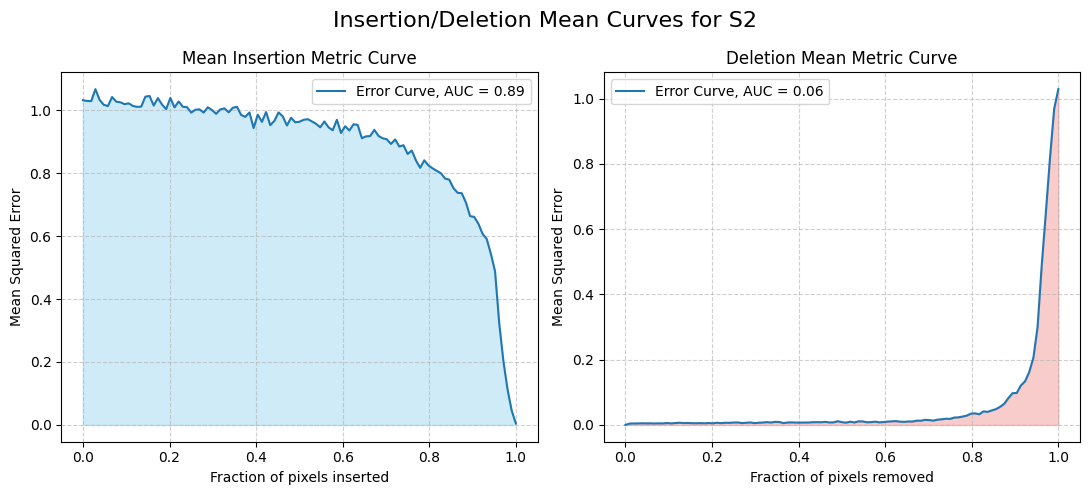

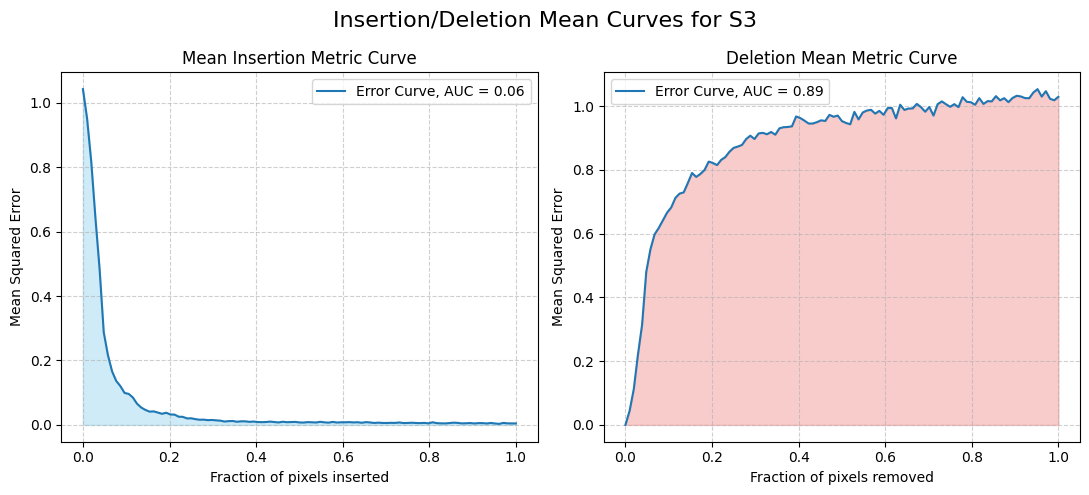

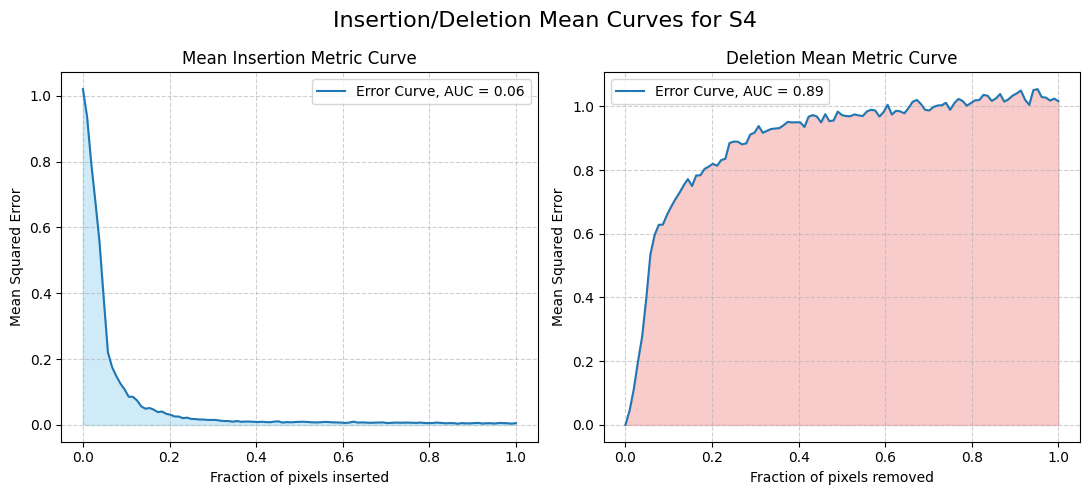

In [ ]:
for index_i in range(2,5):

    s_i_errors_insertion = result_rise_t_l12_p_05["errors_insertion"][:,index_i-1,:]
    s_i_errors_deletion  = result_rise_t_l12_p_05["errors_deletion"][:,index_i-1,:]

    plot_combined_curves(s_i_errors_insertion, s_i_errors_deletion, title=f"Insertion/Deletion Mean Curves for S{index_i}")

[0.38456898 0.38456861 0.38456825 0.38456789 0.38456753 0.38456717
 0.38456682 0.38456647 0.38456612 0.38456577 0.38456579 0.38456602
 0.38456624 0.38456646 0.38456667 0.38456689 0.3845671  0.38456731
 0.38456751 0.38456713 0.38456519 0.38456323 0.38456125 0.38455925
 0.38455722 0.38455517 0.38455309 0.38455099 0.38454887 0.38454958
 0.38455058 0.38455158 0.3845526  0.38455362 0.38455465 0.38455569
 0.38455673 0.38455778 0.38455851 0.38455895 0.38455939 0.38455982
 0.38456025 0.38456068 0.3845611  0.38456152 0.38456194 0.38456267
 0.38456486 0.38456709 0.38456936 0.38457166 0.38457401 0.38457639
 0.38457882 0.38458128 0.38458379 0.38458275 0.38458096 0.38457923
 0.38457753 0.38457589 0.38457428 0.38457272 0.3845712  0.38456972
 0.38456965 0.38457125 0.38457286 0.38457448 0.38457611 0.38457775
 0.3845794  0.38458106 0.38458273 0.3845841  0.38458227 0.38458043
 0.38457855 0.38457665 0.38457472 0.38457277 0.38457078 0.38456877
 0.38456673 0.38459256 0.38462855 0.3846642  0.38469951 0.3847

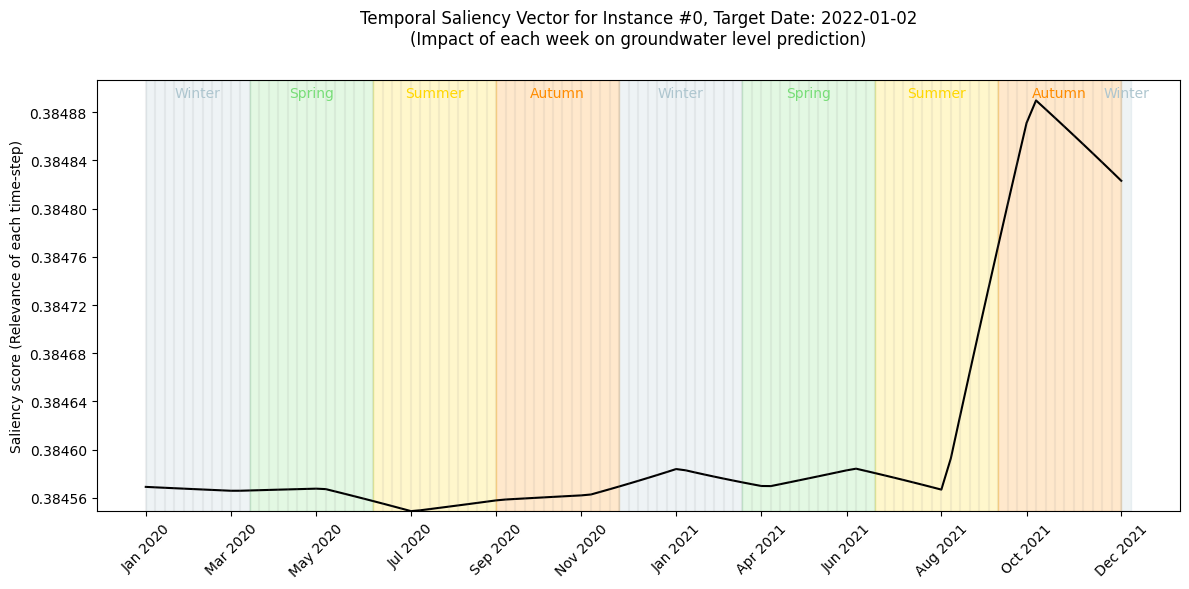

[147.74560609 147.74532449 147.74504498 147.74476752 147.7444921
 147.74421868 147.74394726 147.74367781 147.7434103  147.74314472
 147.74315965 147.74333222 147.7435025  147.74367052 147.74383634
 147.744      147.74416154 147.744321   147.74447843 147.74418814
 147.74269803 147.74119111 147.7396671  147.7381257  147.73656661
 147.73498954 147.73339415 147.73178014 147.73014718 147.73069113
 147.73145904 147.73223248 147.73301152 147.73379622 147.73458664
 147.73538284 147.73618488 147.73699283 147.73754957 147.73789094
 147.73822923 147.73856449 147.73889675 147.73922607 147.73955246
 147.73987598 147.74019666 147.74076042 147.74244572 147.74415887
 147.74590058 147.74767156 147.74947256 147.75130436 147.75316774
 147.75506353 147.75699258 147.75619227 147.75481704 147.75347993
 147.75217936 147.75091386 147.74968204 147.74848256 147.74731417
 147.74617567 147.74612265 147.74735106 147.74858734 147.74983156
 147.75108379 147.75234412 147.75361263 147.75488938 147.75617447
 147.757223

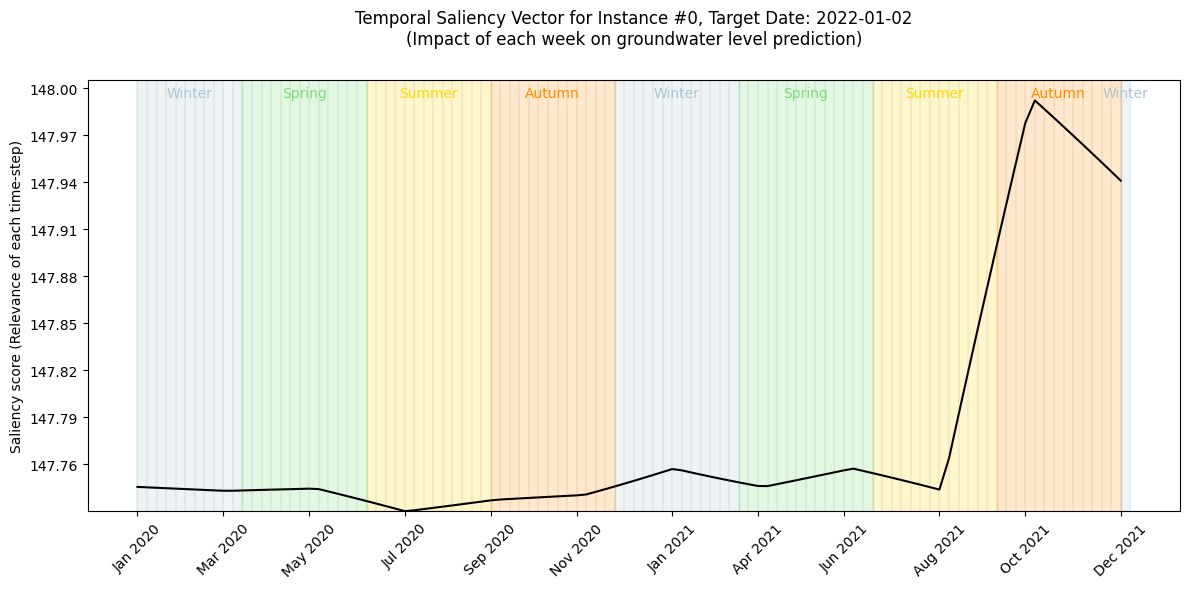

[-384.99879283 -384.9987932  -384.99879357 -384.99879393 -384.99879429
 -384.99879464 -384.998795   -384.99879535 -384.9987957  -384.99879604
 -384.99879602 -384.9987958  -384.99879558 -384.99879536 -384.99879514
 -384.99879493 -384.99879472 -384.99879451 -384.99879431 -384.99879468
 -384.99879662 -384.99879858 -384.99880056 -384.99880257 -384.9988046
 -384.99880665 -384.99880873 -384.99881082 -384.99881295 -384.99881224
 -384.99881124 -384.99881023 -384.99880922 -384.9988082  -384.99880717
 -384.99880613 -384.99880508 -384.99880403 -384.99880331 -384.99880287
 -384.99880243 -384.99880199 -384.99880156 -384.99880114 -384.99880071
 -384.99880029 -384.99879988 -384.99879915 -384.99879695 -384.99879472
 -384.99879246 -384.99879015 -384.99878781 -384.99878542 -384.998783
 -384.99878053 -384.99877802 -384.99877906 -384.99878085 -384.99878259
 -384.99878428 -384.99878593 -384.99878753 -384.99878909 -384.99879061
 -384.99879209 -384.99879216 -384.99879056 -384.99878896 -384.99878734
 -384.998

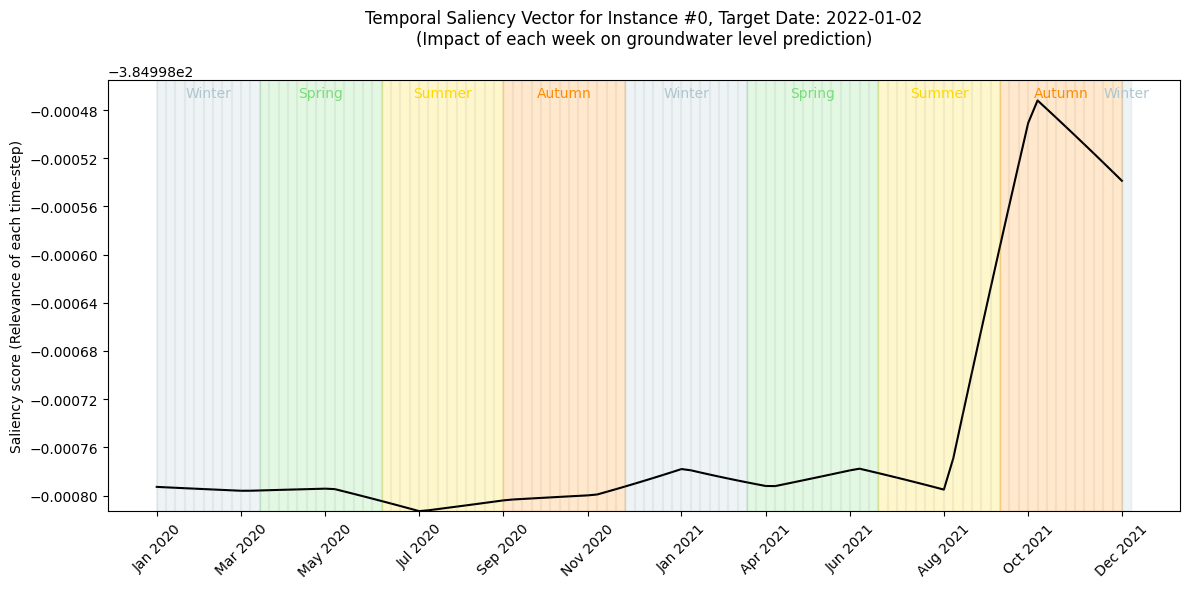

[385.19062306 385.19062306 385.19062306 385.19062306 385.19062306
 385.19062306 385.19062306 385.19062307 385.19062307 385.19062307
 385.19062307 385.19062307 385.19062307 385.19062307 385.19062307
 385.19062306 385.19062306 385.19062306 385.19062306 385.19062306
 385.19062307 385.19062307 385.19062307 385.19062308 385.19062308
 385.19062308 385.19062309 385.19062309 385.19062309 385.19062309
 385.19062309 385.19062309 385.19062308 385.19062308 385.19062308
 385.19062307 385.19062307 385.19062307 385.19062307 385.19062307
 385.19062307 385.19062307 385.19062307 385.19062307 385.19062307
 385.19062307 385.19062307 385.19062307 385.19062307 385.19062307
 385.19062306 385.19062306 385.19062305 385.19062305 385.19062304
 385.19062304 385.19062303 385.19062303 385.19062304 385.19062304
 385.19062304 385.19062304 385.19062305 385.19062305 385.19062305
 385.19062305 385.19062305 385.19062305 385.19062305 385.19062305
 385.19062304 385.19062304 385.19062304 385.19062304 385.19062303
 385.19062

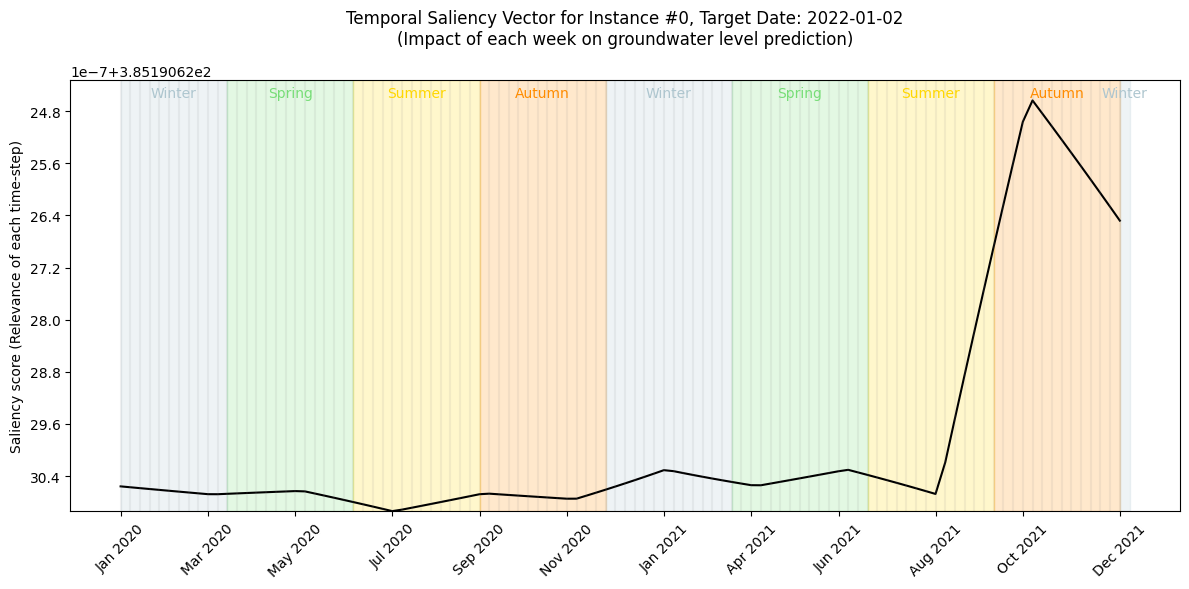

In [134]:
nr_instance = 0
mode = "standard"

for i in range(0,4):
    s_i = result_rise_t_l12_p_05["saliency_vectors"][nr_instance,i,:]
    print(s_i)

    if i == 3:
        mode="to_zero"

    plot_saliency_vector(s_i, vottignasco_test_dates, vottignasco_test_image_dates, nr_instance, mode=mode)

In [2]:
import numpy as np

array = np.array([
    147.74560609, 147.74532449, 147.74504498, 147.74476752, 147.7444921,
    147.74421868, 147.74394726, 147.74367781, 147.7434103,  147.74314472,
    147.74315965, 147.74333222, 147.7435025,  147.74367052, 147.74383634,
    147.744,      147.74416154, 147.744321,   147.74447843, 147.74418814,
    147.74269803, 147.74119111, 147.7396671,  147.7381257,  147.73656661,
    147.73498954, 147.73339415, 147.73178014, 147.73014718, 147.73069113,
    147.73145904, 147.73223248, 147.73301152, 147.73379622, 147.73458664,
    147.73538284, 147.73618488, 147.73699283, 147.73754957, 147.73789094,
    147.73822923, 147.73856449, 147.73889675, 147.73922607, 147.73955246,
    147.73987598, 147.74019666, 147.74076042, 147.74244572, 147.74415887,
    147.74590058, 147.74767156, 147.74947256, 147.75130436, 147.75316774,
    147.75506353, 147.75699258, 147.75619227, 147.75481704, 147.75347993,
    147.75217936, 147.75091386, 147.74968204, 147.74848256, 147.74731417,
    147.74617567, 147.74612265, 147.74735106, 147.74858734, 147.74983156,
    147.75108379, 147.75234412, 147.75361263, 147.75488938, 147.75617447,
    147.75722376, 147.75582413, 147.75440475, 147.75296518, 147.75150499,
    147.75002375, 147.74852099, 147.74699623, 147.745449,   147.74387879,
    147.76373056, 147.79139111, 147.81878876, 147.84592724, 147.87281022,
    147.89944128, 147.92582395, 147.95196168, 147.97785788, 147.99221238,
    147.98668371, 147.98111535, 147.97550686, 147.96985781, 147.96416776,
    147.95843625, 147.95266284, 147.94684707, 147.94098846
])


np.argsort(array)

array([ 28,  29,  30,  27,  31,  32,  26,  33,  34,  25,  35,  36,  24,
        37,  38,  39,  23,  40,  41,  42,  43,  44,  22,  45,  46,  47,
        21,  48,  20,   9,  10,  11,   8,  12,  13,   7,  14,  84,   6,
        15,  49,  16,  19,   5,  17,  18,   4,   3,   2,   1,  83,   0,
        50,  66,  65,  82,  64,  67,  51,  63,  81,  68,  52,  62,  69,
        80,  61,  70,  53,  79,  60,  71,  78,  54,  59,  72,  77,  58,
        73,  55,  76,  74,  57,  56,  75,  85,  86,  87,  88,  89,  90,
        91, 103, 102,  92, 101, 100,  99,  98,  97,  93,  96,  95,  94])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_curves_with_inversion_and_normalization(curves, inverse_curves=None, title='Curva Normalizzata e Invertita', color='blue'):
    """
    Plotta più curve con opzione di normalizzazione (0-1) e inversione selettiva.
    
    Args:
        curves (list or np.array): Matrice (n_curves, n_points) contenente le curve.
        inverse_curves (list or np.array): Indici delle curve da invertire.
        title (str): Titolo del grafico.
        color (str): Colore principale per la curva media e la banda della dev. standard.
    """
    curves = np.array(curves)
    inverse_curves = inverse_curves or []

    # Funzione per normalizzare le curve tra 0 e 1
    def normalize_curve(curve):
        min_val = np.min(curve)
        max_val = np.max(curve)
        return (curve - min_val) / (max_val - min_val)

    # Normalizza tutte le curve
    curves = np.array([normalize_curve(curve) for curve in curves])

    # Inverti le curve selezionate
    for i in inverse_curves:
        curves[i] = 1 - curves[i]  # Inversione (da 1 a 0)

    # Asse X
    x = np.arange(curves.shape[1])
    
    # Calcolo della media e deviazione standard
    mean_curve = np.mean(curves, axis=0)
    std_curve = np.std(curves, axis=0)
    
    # Plot delle curve individuali
    plt.figure(figsize=(10, 6))
    for i, curve in enumerate(curves):
        label = f'Curva {i+1}'
        style = 'dashed' if i in inverse_curves else 'solid'
        plt.plot(x, curve, linestyle=style, color='skyblue', alpha=0.5, label=label)
    
    # Curva media tratteggiata
    plt.plot(x, mean_curve, color=color, linestyle='--', linewidth=2, label='Media')
    
    # Banda della deviazione standard
    plt.fill_between(x, mean_curve - std_curve, mean_curve + std_curve, color=color, alpha=0.2, label='±1 Dev. Std.')
    
    # Personalizzazioni
    plt.title(title)
    plt.xlabel('Time-step')
    plt.ylabel('Importanza (normalizzata)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Mostra il grafico
    plt.show()



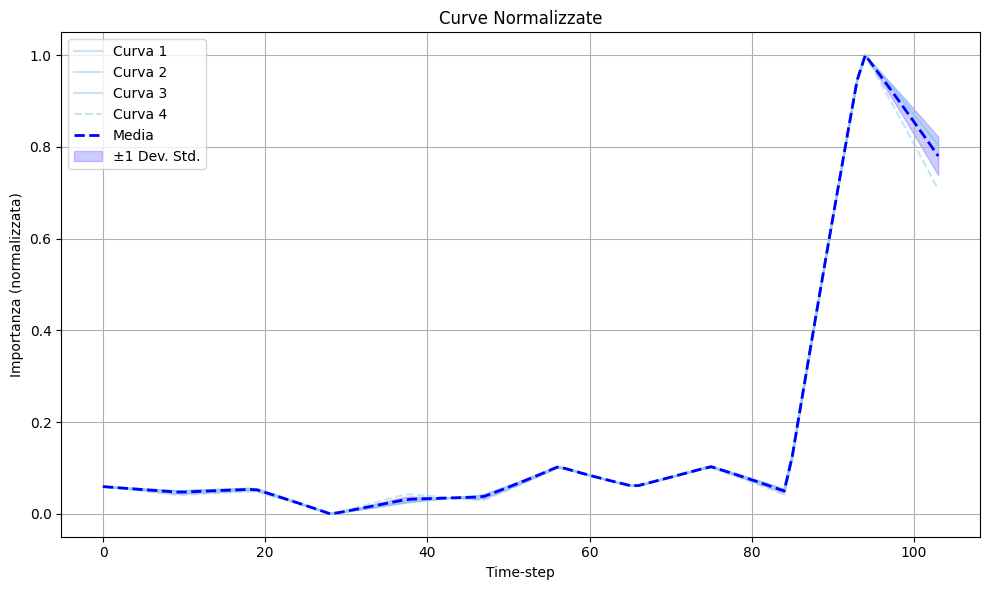

In [143]:
# Esempio: ultima curva invertita, con normalizzazione per tutte
plot_curves_with_inversion_and_normalization(result_rise_t_l12_p_05["saliency_vectors"][0,:,:], inverse_curves=[3], title="Curve Normalizzate")